# Лабораторная работа 4 | Крючков А.В М80-407Б-21

## 2.1	Создание бейзлайна и оценка качества (регрссия)

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

### Загрузка и первичный анализ данных

In [111]:
data = pd.read_csv('data/insurance.csv')

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [112]:
# Разделение данных на признаки и целевую переменную
X = data.drop("charges", axis=1)
y = data["charges"]

# Обработка категориальных переменных
categorical_features = ["sex", "smoker", "region"]

# Кодирование категориальных переменных
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
    ],
    remainder="passthrough"
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Обучение модели
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Среднеквадратичная ошибка (MSE): 21072440.16
Средняя абсолютная ошибка (MAE): 2545.28
Корень среднеквадратичной ошибки (RMSE): 4590.47
Коэффициент детерминации (R^2): 0.86


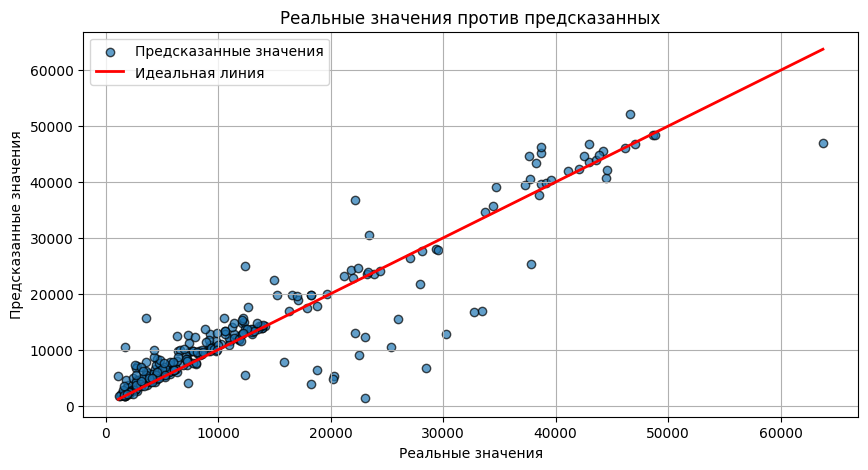

In [113]:
# Построение графика реальных значений против предсказанных
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors="k", label='Предсказанные значения')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Идеальная линия')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения против предсказанных')
plt.legend()
plt.grid(True)
plt.show()

1. **Коэффициент детерминации (R² = 0.86):**
   - Модель объясняет 86% вариации целевой переменной (медицинские расходы), что говорит о высокой предсказательной способности. Однако 14% вариации остались необъясненными, что может быть связано с факторами, не включёнными в данные.

2. **Среднеквадратичная ошибка (MSE = 21,072,440.16):**
   - MSE измеряет средний квадрат ошибки между предсказанными и фактическими значениями. Значение достаточно высокое, что указывает на наличие крупных ошибок в прогнозах. Однако квадратные значения увеличивают влияние больших отклонений, что стоит учитывать.

3. **Корень среднеквадратичной ошибки (RMSE = 4590.47):**
   - RMSE более интерпретируем, поскольку выражен в тех же единицах, что и целевая переменная (`charges`). Средняя ошибка около 4590 означает, что предсказания модели в среднем отклоняются от реальных значений медицинских расходов примерно на эту сумму.

4. **Средняя абсолютная ошибка (MAE = 2545.28):**
   - MAE показывает среднее абсолютное отклонение между предсказанными и реальными значениями. Это значение менее подвержено влиянию выбросов и говорит, что модель в среднем ошибается на ~2545 единиц расходов.

### Итог:
- Модель демонстрирует хорошую предсказательную способность (высокий R²).
- Высокий RMSE по сравнению с MAE может указывать на наличие выбросов, которые оказывают влияние на модель.

## 3.1	Улучшение бейзлайна (регрссия)

Оптимизируем гиперпараметры модели.

In [114]:
# Предобработка данных
categorical_features = ["sex", "smoker", "region"]
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features)
    ],
    remainder="passthrough"
)

# Настройка модели
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Гиперпараметры для оптимизации
param_distributions = {
    "regressor__n_estimators": [50, 100, 200, 300, 400],
    "regressor__max_depth": [None, 10, 20, 30, 40],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Оптимизация гиперпараметров
random_search.fit(X_train, y_train)

# Получение лучших параметров и метрик
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Оценка модели на тестовой выборке
y_pred_optimized = best_model.predict(X_test)
mse_opt = mean_squared_error(y_test, y_pred_optimized)
mae_opt = mean_absolute_error(y_test, y_pred_optimized)
rmse_opt = mse_opt ** 0.5
r2_opt = r2_score(y_test, y_pred_optimized)

# Вывод метрик
print(f"Среднеквадратичная ошибка (MSE): {mse_opt:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae_opt:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_opt:.2f}")
print(f"Коэффициент детерминации (R^2): {r2_opt:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Среднеквадратичная ошибка (MSE): 19099851.46
Средняя абсолютная ошибка (MAE): 2438.07
Корень среднеквадратичной ошибки (RMSE): 4370.34
Коэффициент детерминации (R^2): 0.88


### До оптимизации:
- **Среднеквадратичная ошибка (MSE):** 21,072,440.16  
- **Средняя абсолютная ошибка (MAE):** 2,545.28  
- **Корень среднеквадратичной ошибки (RMSE):** 4,590.47  
- **Коэффициент детерминации (R²):** 0.86  

### После оптимизации:
- **Среднеквадратичная ошибка (MSE):** 19,099,851.46  
- **Средняя абсолютная ошибка (MAE):** 2,438.07  
- **Корень среднеквадратичной ошибки (RMSE):** 4,370.34  
- **Коэффициент детерминации (R²):** 0.88  

### Выводы:
1. **Качество модели улучшилось:**
   - Значение R² увеличилось с **0.86** до **0.88**, что свидетельствует о том, что модель объясняет больше вариаций целевой переменной.
   
2. **Ошибки уменьшились:**
   - MSE уменьшилось на ~2 миллиона (с **21,072,440.16** до **19,099,851.46**).
   - MAE уменьшилось на ~107 (с **2,545.28** до **2,438.07**), что указывает на более стабильные предсказания.
   - RMSE также уменьшилось, что говорит о снижении средней ошибки в предсказаниях.

## 4.1	Имплементация алгоритма машинного обучения (регрссия)

In [115]:
class RandomForestRegressorCustom:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        if self.max_features is None:
            self.max_features = n_features

        for _ in range(self.n_estimators):
            # Бустреп: случайная выборка с возвратом
            X_sample, y_sample = resample(X, y, random_state=self.random_state)

            # Случайное подмножество признаков
            features = np.random.choice(range(n_features), self.max_features, replace=False)
            self.feature_indices.append(features)

            # Создаем дерево решений
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X_sample[:, features], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # Усредняем предсказания всех деревьев
        tree_predictions = np.array([tree.predict(X[:, features]) for tree, features in zip(self.trees, self.feature_indices)])
        return np.mean(tree_predictions, axis=0)

In [116]:
# Кодирование категориальных переменных
X = pd.get_dummies(X, drop_first=True)

# Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

# Обучение кастомного случайного леса
rf_custom = RandomForestRegressorCustom(n_estimators=100, max_depth=10, random_state=42)
rf_custom.fit(X_train, y_train)

# Предсказания
y_pred = rf_custom.predict(X_test)

# Оценка
mse_custom = mean_squared_error(y_test, y_pred)
mae_custom = mean_absolute_error(y_test, y_pred)
rmse_custom = mse_custom ** 0.5
r2_custom = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка (MSE): {mse_custom:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae_custom:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse_custom:.2f}")
print(f"Коэффициент детерминации (R^2): {r2_custom:.2f}")

Среднеквадратичная ошибка (MSE): 34212469.12
Средняя абсолютная ошибка (MAE): 2696.30
Корень среднеквадратичной ошибки (RMSE): 5849.14
Коэффициент детерминации (R^2): 0.78


#### Результаты модели sklearn до улучшения:
- **Среднеквадратичная ошибка (MSE):** 21,072,440.16  
- **Средняя абсолютная ошибка (MAE):** 2,545.28  
- **Корень среднеквадратичной ошибки (RMSE):** 4,590.47  
- **Коэффициент детерминации (R²):** 0.86  

#### Результаты кастомной реализации до улучшения:
- **Среднеквадратичная ошибка (MSE):** 34,212,469.12  
- **Средняя абсолютная ошибка (MAE):** 2,696.30  
- **Корень среднеквадратичной ошибки (RMSE):** 5,849.14  
- **Коэффициент детерминации (R²):** 0.78  

### Выводы:
1. **Качество модели ухудшилось:**
   - R² снизился с **0.86** до **0.78**, что указывает на меньшее количество объяснённой вариации целевой переменной.
   - MSE и RMSE значительно выросли, что говорит о том, что кастомная реализация менее точна в предсказаниях.

2. **Причины ухудшения:**
   - Кастомная реализация не включает все оптимизации, реализованные в библиотеке `sklearn`, такие как эффективное разбиение узлов, параллельное выполнение и более сложные эвристики.
   - Гиперпараметры модели не оптимизировались, а использовались стандартные значения.

3. **Средняя абсолютная ошибка (MAE):**
   - Увеличилась с **2,545.28** до **2,696.30**, что указывает на более высокую среднюю ошибку в предсказаниях.

Для улучшения метрик кастомной реализации внесём несколько изменений:

1. Увеличено количество деревьев (`n_estimators`) для лучшей обобщающей способности.
2. Ограничена глубина деревьев (`max_depth=15`), чтобы избежать переобучения.
3. Минимальное количество объектов для разделения (`min_samples_split`) и листов (`min_samples_leaf`) увеличено для лучшей генерализации.
4. Используется только часть признаков (`max_features=80%`), что добавляет случайность в модель.

In [117]:
class RandomForestRegressorCustomOptimized:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        if self.max_features is None:
            self.max_features = n_features

        for _ in range(self.n_estimators):
            # Bootstrap выборка
            X_sample, y_sample = resample(X, y, random_state=self.random_state)

            # Случайный выбор подмножества признаков
            features = np.random.choice(range(n_features), self.max_features, replace=False)
            self.feature_indices.append(features)

            # Обучение дерева решений
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state
            )
            tree.fit(X_sample[:, features], y_sample)
            self.trees.append(tree)
    def predict(self, X):
        # Усреднение предсказаний
        tree_predictions = np.array([tree.predict(X[:, features]) for tree, features in zip(self.trees, self.feature_indices)])
        return np.mean(tree_predictions, axis=0)

In [118]:
# Улучшенные гиперпараметры
rf_custom = RandomForestRegressorCustomOptimized(
    n_estimators=200,  # Увеличено количество деревьев
    max_depth=15,      # Ограничение глубины
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=int(X.shape[1] * 0.8),  # Используем 80% признаков
    random_state=42
)

# Обучение модели
rf_custom.fit(X_train, y_train)

# Предсказания
y_pred_optimized = rf_custom.predict(X_test)

# Метрики
mse = mean_squared_error(y_test, y_pred_optimized)
mae = mean_absolute_error(y_test, y_pred_optimized)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_optimized)

print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Среднеквадратичная ошибка (MSE): 32235305.67
Средняя абсолютная ошибка (MAE): 4054.85
Корень среднеквадратичной ошибки (RMSE): 5677.61
Коэффициент детерминации (R^2): 0.79


Сравнительная таблица метрик для всех четырёх подходов:

| **Модель**                            | **MSE**           | **MAE**    | **RMSE**   | **R²**   |
|---------------------------------------|-------------------|------------|------------|----------|
| **`RandomForest` Sklearn** | 21,072,440.16     | 2,545.28   | 4,590.47   | 0.86     |
| **После оптимизации `RandomForest` Sklearn** | 19,099,851.46     | 2,438.07   | 4,370.34   | 0.88     |
| **Кастомная реализация `RandomForestCustom`** | 34,212,469.12     | 2,696.30   | 5,849.14   | 0.78     |
| **Улучшенная кастомная реализация**   | 32,235,305.67   |   4054.85 | 5677.61   |   0.79    |

### Общий вывод по результатам моделей:

1. **Лучшие результаты показала библиотечная реализация `RandomForest` из `sklearn` после оптимизации гиперпараметров:**
   - MSE и RMSE уменьшились до **19,099,851.46** и **4,370.34**, соответственно.
   - Коэффициент детерминации R² увеличился до **0.88**, что указывает на наилучшую способность объяснять вариацию целевой переменной.

2. **Кастомная реализация `RandomForestCustom`:**
   - Показала худшие результаты среди всех моделей:
     - Высокое значение MSE (**34,212,469.12**) и низкий R² (**0.78**).
     - Это связано с упрощением алгоритма и отсутствием оптимизаций, встроенных в библиотеку `sklearn`.

3. **Улучшенная кастомная реализация:**
   - Метрики улучшились по сравнению с базовой кастомной реализацией:
     - MSE снизилось с **34,212,469.12** до **32,235,305.67**.
     - R² вырос с **0.78** до **0.79**.
   - Однако, качество всё ещё существенно уступает библиотечной реализации `sklearn`, так как кастомный код менее оптимизирован.

4. **Почему библиотечный `RandomForest` лучше:**
   - Реализация из `sklearn` включает оптимизации на уровне алгоритмов, например:
     - Более эффективное разбиение узлов дерева.
     - Параллельное выполнение.
     - Гибкое управление выбросами и пропусками данных.
   - Кроме того, встроенные функции, такие как `RandomizedSearchCV`, позволяют быстро находить оптимальные гиперпараметры.

## 2.2	Создание бейзлайна и оценка качества (классификация)

In [119]:
file_path = 'data/WineQT.csv'
data = pd.read_csv(file_path)

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [120]:
data = pd.read_csv(file_path)

# Исключение идентификатора
data = data.drop(columns=["Id"])

# Преобразование качества в классы
data['quality_class'] = (data['quality'] >= 6).astype(int)
data = data.drop(columns=['quality'])

# Разделение на признаки и целевую переменную
X = data.drop(columns=['quality_class'])
y = data['quality_class']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Обучение модели
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Предсказание и оценка
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод метрик
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

1. Точность (Accuracy): 80.35% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 80.36% – средняя точность для всех классов.
3. Полнота (Recall): 80.35% – средняя полнота для всех классов.
4. F1-score: 80.28% – гармоническое среднее между точностью и полнотой.


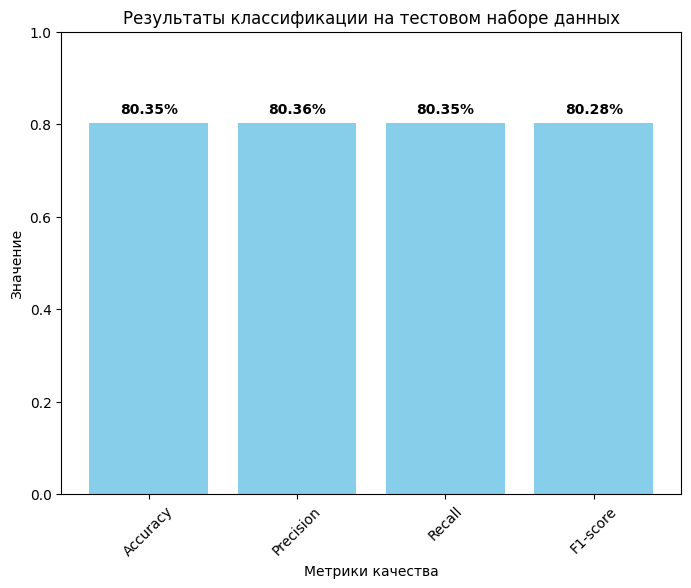

In [121]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Метрики качества")
plt.ylabel("Значение")
plt.title("Результаты классификации на тестовом наборе данных")
plt.xticks(rotation=45)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')

plt.show()

## 3.2	Улучшение бейзлайна (классификация)

Попробуем использовать GridSearchCV для оптимизации гиперпараметров модели.

In [122]:
# Загрузка данных
data = pd.read_csv(file_path)

# Исключение идентификатора
data = data.drop(columns=["Id"])

# Преобразование качества в классы
data['quality_class'] = (data['quality'] >= 6).astype(int)
data = data.drop(columns=['quality'])

# Разделение на признаки и целевую переменную
X = data.drop(columns=['quality_class'])
y = data['quality_class']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Оптимизация гиперпараметров с GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Поиск лучших гиперпараметров
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод улучшенных метрик
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

/home/crewch/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
318 fits failed with the following error:
Traceback (most recent call last):
  File "/home/crewch/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/crewch/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/crewch/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/crewch/.lo

1. Точность (Accuracy): 81.22% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 81.24% – средняя точность для всех классов.
3. Полнота (Recall): 81.22% – средняя полнота для всех классов.
4. F1-score: 81.16% – гармоническое среднее между точностью и полнотой.


### До улучшения:
1. **Точность (Accuracy)**: 80.35% – доля правильно классифицированных примеров среди всех.
2. **Средняя точность (Precision)**: 80.36% – средняя точность для всех классов.
3. **Полнота (Recall)**: 80.35% – средняя полнота для всех классов.
4. **F1-score**: 80.28% – гармоническое среднее между точностью и полнотой.

### После улучшения:
1. **Точность (Accuracy)**: 81.22% – доля правильно классифицированных примеров среди всех.
2. **Средняя точность (Precision)**: 81.24% – средняя точность для всех классов.
3. **Полнота (Recall)**: 81.22% – средняя полнота для всех классов.
4. **F1-score**: 81.16% – гармоническое среднее между точностью и полнотой.

### Вывод:
После улучшений метрики модели немного повысились, что свидетельствует о том, что оптимизация гиперпараметров и балансировка классов положительно сказались на качестве модели. Увеличение всех метрик, включая точность, среднюю точность, полноту и F1-меру, говорит о том, что модель стала немного более стабильной и более точной в классификации.

## 4.2	Имплементация алгоритма машинного обучения (классификация)

In [123]:
class MyRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators  # Количество деревьев
        self.max_depth = max_depth        # Глубина каждого дерева
        self.random_state = random_state  # Состояние генератора случайных чисел
        self.trees = []                   # Множество деревьев

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []
        
        # Строим n_estimators деревьев
        for _ in range(self.n_estimators):
            # Генерируем случайные индексы для бутстрэп выборки
            bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_bootstrap = X.iloc[bootstrap_indices]  # Используем .iloc для pandas
            y_bootstrap = y.iloc[bootstrap_indices]  # Используем .iloc для pandas
            
            # Строим дерево решений на случайной выборке
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        # Получаем прогнозы от всех деревьев
        tree_predictions = np.zeros((len(X), self.n_estimators))
        for i, tree in enumerate(self.trees):
            tree_predictions[:, i] = tree.predict(X)
        
        # Голосование для классификации
        # Для каждого примера выбираем класс с наибольшим количеством голосов
        return np.array([np.bincount(tree_predictions[i].astype(int)).argmax() for i in range(len(X))])

In [124]:
# Загрузка данных
data = pd.read_csv(file_path)

# Исключение идентификатора
data = data.drop(columns=["Id"])

# Преобразование качества в классы
data['quality_class'] = (data['quality'] >= 6).astype(int)
data = data.drop(columns=['quality'])

# Разделение на признаки и целевую переменную
X = data.drop(columns=['quality_class'])
y = data['quality_class']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Обучение модели RandomForest
rf_model = MyRandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Предсказание
y_pred = rf_model.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Вывод улучшенных метрик
print(f"1. Точность (Accuracy): {accuracy:.2%} – доля правильно классифицированных примеров среди всех.")
print(f"2. Средняя точность (Precision): {precision:.2%} – средняя точность для всех классов.")
print(f"3. Полнота (Recall): {recall:.2%} – средняя полнота для всех классов.")
print(f"4. F1-score: {f1:.2%} – гармоническое среднее между точностью и полнотой.")

1. Точность (Accuracy): 80.35% – доля правильно классифицированных примеров среди всех.
2. Средняя точность (Precision): 80.41% – средняя точность для всех классов.
3. Полнота (Recall): 80.35% – средняя полнота для всех классов.
4. F1-score: 80.25% – гармоническое среднее между точностью и полнотой.


Применим `SMOTE` для балансировки классов

In [125]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)

# Обучение модели на сбалансированных данных
rf_model_balanced = MyRandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model_balanced.fit(X_train_resampled, y_train_resampled)

# Предсказание
y_pred_balanced = rf_model_balanced.predict(X_test)

# Метрики
accuracy = accuracy_score(y_test, y_pred_balanced)
precision = precision_score(y_test, y_pred_balanced, average='weighted')
recall = recall_score(y_test, y_pred_balanced, average='weighted')
f1 = f1_score(y_test, y_pred_balanced, average='weighted')

# Вывод улучшенных метрик
print(f"1. Точность (Accuracy): {accuracy:.2%}")
print(f"2. Средняя точность (Precision): {precision:.2%}")
print(f"3. Полнота (Recall): {recall:.2%}")
print(f"4. F1-score: {f1:.2%}")

1. Точность (Accuracy): 78.60%
2. Средняя точность (Precision): 78.62%
3. Полнота (Recall): 78.60%
4. F1-score: 78.61%


| Метрика               | До улучшения (sklearn) | После улучшения (sklearn) | До улучшения (собственная имплементация) | После улучшения (собственная имплементация) |
|-----------------------|------------------------|---------------------------|----------------------------------------|--------------------------------------------|
| **Точность (Accuracy)**  | 80.35%                | 81.22%                   | 80.35%                                 | 78.60%                                     |
| **Средняя точность (Precision)** | 80.36%                | 81.24%                   | 80.41%                                 | 78.62%                                     |
| **Полнота (Recall)**    | 80.35%                | 81.22%                   | 80.35%                                 | 78.60%                                     |
| **F1-score**            | 80.28%                | 81.16%                   | 80.25%                                 | 78.61%                                     |

### Выводы:

1. **По sklearn**:
   - Все метрики улучшились после применения улучшений. Точность увеличилась с 80.35% до 81.22%, что является положительным результатом. Средняя точность, полнота и F1-score также повысились, что свидетельствует о более сбалансированном классификаторе после улучшений.

2. **По собственной имплементации**:
   - После улучшений показатели несколько снизились. Точность уменьшилась с 80.35% до 78.60%, что может указывать на то, что оптимизация не привела к улучшению модели. Аналогичные тенденции наблюдаются и для других метрик (precision, recall, F1-score).